<h1> <center> Telecom Churn - ML Group Case Study </center> </h1>

# Business Problem

The telecommunication industry experience an average of 15-25% annual churn rate. According to research, its 5-10 times difficult to retain a customer than to acquire one, customer retention has now become even more important than customer acquisition.
To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

### Definition of Churn :
Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time. A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

### Problem Statement :
Build a predictive model to predict usage-based churn of high value customers in the near future. This will help the company in both retaihning the customer as well as understanding the strong predictors from the model and acting based on that.

In [82]:
# Import Libraries
import pandas as pd
import numpy as np
import string
import warnings
warnings.filterwarnings('ignore')
import qgrid
from pandas_profiling import ProfileReport

import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import HTML

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import shap

In [12]:
# Read Data
df = pd.read_csv('telecom_churn_data.csv')

qgrid.show_grid(df, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100}, show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [6]:
# Check the number of rows and columns
df.shape

(99999, 226)

In [8]:
# Check the column names
df.columns.tolist()

['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 's

# Exploratory Data Analysis

In [16]:
# Create a initial profile report of data
profile = ProfileReport(df, title="Pandas Profiling Report", minimal=True)
profile.to_file("report.html")

In [76]:
HTML(filename='report.html')

### Observations from Above Report

- There are columns with more than 70 % missing, which needs to be removed in further steps.
- There are columns with no variance(unique value throughout), which needs to be removed in further steps.
- Handling NaN's cannot be done directly with imputation, as there may be a reason why it is missing. Will be imputing in further steps using median for PCA and with -999 for Tree Based Models
- Most of the columns are Right skewed.

### High Value Customers based on given definition :
Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [102]:
# Average recharge amount for first two months i.e 6 and 7
# Removing negative values from the Average recharge amount for first two months with 0
# Replacing NaN's with 0
arpu_6_7 = (df['arpu_6'].fillna(0) + df['arpu_7'].fillna(0))/2
arpu_6_7 = arpu_6_7[arpu_6_7 >= 0]
arpu_6_7.describe(percentiles = [0.7])['70%']


317.5723

In [103]:
arpu_6_7 = pd.Series(np.where(arpu_6_7 >= arpu_6_7.describe(percentiles = [0.7])['70%'], 1, 0))
arpu_6_7 = arpu_6_7.value_counts().reset_index()
arpu_6_7.columns = ['index','value']

In [104]:
arpu_6_7.iplot(kind='pie',labels='index',values='value',title = 'What is the percentage of high value customers based on the given condition ?',pull=.05,colors = ["dimgrey","orange"],
           textposition='inside',textinfo='value+percent')

### Number of Customers Churned based on Usage
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:
- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

In [105]:
# Total Usage of incoming, outgoing, 2 g and 3g for month 9
# Removing negative values with 0

decision_var = df['total_ic_mou_9'].fillna(0) + df['total_og_mou_9'].fillna(0) + df['vol_2g_mb_9'].fillna(0) + df['vol_3g_mb_9'].fillna(0)
decision_var = decision_var[decision_var >= 0]
decision_var.head()

0      0.00
1    260.15
2    651.10
3    667.92
4    309.90
dtype: float64

In [106]:
decision_var = pd.Series(np.where(decision_var == 0, 1, 0))
decision_var = decision_var.value_counts().reset_index()
decision_var.columns = ['index','value']

In [107]:
decision_var.iplot(kind='pie',labels='index',values='value',title = 'What is the percentage of Churned customers based on Usage ?',pull=.05,colors = ["dimgrey","orange"],
           textposition='inside',textinfo='value+percent')

### Number of High Value Churned Customers based on Usage ?

In [108]:
arpu_6_7 = (df['arpu_6'].fillna(0) + df['arpu_7'].fillna(0))/2
arpu_6_7 = arpu_6_7[arpu_6_7 >= 0]

decision_var = df['total_ic_mou_9'].fillna(0) + df['total_og_mou_9'].fillna(0) + df['vol_2g_mb_9'].fillna(0) + df['vol_3g_mb_9'].fillna(0)
decision_var = decision_var[decision_var >= 0]

x = pd.DataFrame([arpu_6_7, decision_var]).T
x.columns = ['high_value_decision','churned_decision']

In [109]:
high_value_churned = pd.Series(np.where((x.high_value_decision >= x['high_value_decision'].describe(percentiles = [0.7])['70%']) & (x.churned_decision == 0), 1, 0))
high_value_churned = high_value_churned.value_counts().reset_index()
high_value_churned.columns = ['index','value']

In [110]:
high_value_churned.iplot(kind='pie',labels='index',values='value',title = 'What is the percentage of High Value Churned customers based on Usage ?',pull=.05,colors = ["dimgrey","orange"],
           textposition='inside',textinfo='value+percent')

In [111]:
high_value_churned = x[(x.high_value_decision >= x['high_value_decision'].describe(percentiles = [0.7])['70%'])]
high_value_churned = pd.Series(np.where((high_value_churned.churned_decision == 0), 1, 0))
high_value_churned = high_value_churned.value_counts().reset_index()
high_value_churned.columns = ['index','value']

In [112]:
high_value_churned.iplot(kind='pie',labels='index',values='value',title = 'What is the percentage of Churned customers based on Usage in High Value Customer Base ?',pull=.05,colors = ["dimgrey","orange"],
           textposition='inside',textinfo='value+percent')

# Data Prepration

## 1. Getting only the High Value Customer Base

In [225]:
# Average recharge amount for first two months i.e 6 and 7
# Removing negative values from the Average recharge amount for first two months with 0
# Replacing NaN's with 0
arpu_6_7 = (df['arpu_6'].fillna(0) + df['arpu_7'].fillna(0))/2
# Customer having greater than or equal to 70th percentile of arpu on 6th and 7th month.
arpu_6_7 = pd.Series(np.where(arpu_6_7 >= 317.5723, 1, 0))
print(len(arpu_6_7), len(df))
telecom_churn = df.iloc[np.where(arpu_6_7 == 1)].reset_index(drop = True)
telecom_churn.head()

99999 99999


mobile_number  circle_id  loc_og_t2o_mou  ...  jul_vbc_3g  jun_vbc_3g sep_vbc_3g
0     7000701601        109             0.0  ...       19.38       18.74        0.0
1     7001524846        109             0.0  ...      910.65      122.16        0.0
2     7002191713        109             0.0  ...        0.00        0.00        0.0
3     7000875565        109             0.0  ...        2.45       21.89        0.0
4     7000187447        109             0.0  ...        0.00        0.00        0.0

[5 rows x 226 columns]

## 2. Dropping Column with No Variance

In [226]:
# Columns with constant value
telecom_churn.loc[:,telecom_churn.apply(pd.Series.nunique) == 1].columns

Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6',
       'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'],
      dtype='object')

In [227]:
# Dropping columns with constant value or no variance
#telecom_churn.loc[:,telecom_churn.apply(pd.Series.nunique) == 1].columns
telecom_churn = telecom_churn.loc[:,telecom_churn.apply(pd.Series.nunique) != 1]
print(telecom_churn.shape)
telecom_churn.head()

(29964, 210)


mobile_number    arpu_6    arpu_7  ...  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g
0     7000701601  1069.180  1349.850  ...       19.38       18.74         0.0
1     7001524846   378.721   492.223  ...      910.65      122.16         0.0
2     7002191713   492.846   205.671  ...        0.00        0.00         0.0
3     7000875565   430.975   299.869  ...        2.45       21.89         0.0
4     7000187447   690.008    18.980  ...        0.00        0.00         0.0

[5 rows x 210 columns]

## 3. Converting into Appropriate Data Type

In [208]:
qgrid.show_grid(telecom_churn, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100}, show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [228]:
# Automatically Converting to Date Columns if recognised
for col in telecom_churn.columns:
    if telecom_churn[col].dtype == 'object':
        try:
            telecom_churn[col] = pd.to_datetime(telecom_churn[col])
        except ValueError:
            pass

In [229]:
date_cols = telecom_churn.select_dtypes(include = 'datetime64').columns
telecom_churn[date_cols]

date_of_last_rech_6  ... date_of_last_rech_data_9
0              2014-06-27  ...                      NaT
1              2014-06-25  ...                      NaT
2              2014-06-20  ...                      NaT
3              2014-06-30  ...                      NaT
4              2014-06-30  ...                      NaT
...                   ...  ...                      ...
29959          2014-06-29  ...                      NaT
29960          2014-06-17  ...                      NaT
29961          2014-06-20  ...               2014-09-16
29962          2014-06-30  ...               2014-09-19
29963          2014-06-16  ...                      NaT

[29964 rows x 8 columns]

## 3. Imputing Nan's

In [231]:
# Imputing NaN's with median because there are extreme values which tend to pull the mean.
telecom_churn_imputed = telecom_churn.drop(date_cols, axis=1).fillna(telecom_churn.drop(date_cols, axis=1).median())
telecom_churn_imputed = pd.concat([telecom_churn_imputed, telecom_churn[date_cols]], axis = 1)

## 4. Creating Churn Target Column

In [232]:
# Creating the target variable by using the given condition
telecom_churn_imputed['churned'] = telecom_churn_imputed['total_ic_mou_9'] + telecom_churn_imputed['total_og_mou_9'] + telecom_churn_imputed['vol_2g_mb_9'] + telecom_churn_imputed['vol_3g_mb_9']
telecom_churn_imputed['churned'] = telecom_churn_imputed['churned'].apply(lambda x: 1 if x==0 else 0)
telecom_churn_imputed = telecom_churn_imputed.drop(['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9'], axis = 1)

#### Note : Removing all columns for the Month 9 has this is the churn phase and cannot be used in training the data

In [233]:
columns_to_delete = [x for x in telecom_churn_imputed.columns if x.endswith('_9')]
telecom_churn_imputed = telecom_churn_imputed.drop(columns_to_delete, axis = 1)

## 5. Feature Engineering

In [234]:
telecom_churn_imputed.columns.tolist()

['mobile_number',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_

In [235]:
qgrid.show_grid(telecom_churn_imputed, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100}, show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### Feature 1 : Mean of difference between consecutive months last date of recharge which gives mean interval between recharges

In [244]:
x1 = telecom_churn_imputed['date_of_last_rech_7'] - telecom_churn_imputed['date_of_last_rech_6']
x2 = telecom_churn_imputed['date_of_last_rech_8'] - telecom_churn_imputed['date_of_last_rech_7']
f1 = pd.DataFrame([x1,x2]).T
f1.columns = ['diff_1','diff_2']
f1['diff_1'] = pd.to_numeric(f1['diff_1'].dt.days, downcast='integer')
f1['diff_2'] = pd.to_numeric(f1['diff_2'].dt.days, downcast='integer')
f1['mean_int_bw_rech'] = f1.mean(axis = 1)
telecom_churn_imputed['mean_int_bw_rech'] = f1['mean_int_bw_rech']
telecom_churn_imputed['mean_int_bw_rech'] = telecom_churn_imputed['mean_int_bw_rech'].fillna(f1.mean_int_bw_rech.median())

In [245]:
x1 = telecom_churn_imputed['date_of_last_rech_data_7'] - telecom_churn_imputed['date_of_last_rech_data_6']
x2 = telecom_churn_imputed['date_of_last_rech_data_8'] - telecom_churn_imputed['date_of_last_rech_data_7']
f1 = pd.DataFrame([x1,x2]).T
f1.columns = ['diff_1','diff_2']
f1['diff_1'] = pd.to_numeric(f1['diff_1'].dt.days, downcast='integer')
f1['diff_2'] = pd.to_numeric(f1['diff_2'].dt.days, downcast='integer')
f1['mean_int_bw_rech_data'] = f1.mean(axis = 1)
telecom_churn_imputed['mean_int_bw_rech_data'] = f1['mean_int_bw_rech_data']
telecom_churn_imputed['mean_int_bw_rech_data'] = telecom_churn_imputed['mean_int_bw_rech_data'].fillna(f1.mean_int_bw_rech_data.median())

In [247]:
date_cols

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9'],
      dtype='object')

In [248]:
# Dropping Date Columns
telecom_churn_imputed = telecom_churn_imputed.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
                                                    'date_of_last_rech_data_6',
                                                    'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis = 1)

### Feature 2: Find the trend between month 6, 7 and 8 and get the the beta coefficient for usage based columns

In [249]:
telecom_churn_imputed.columns.tolist()

['mobile_number',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_

In [251]:
# Getting Usage based columns and scheme based columns
scheme_based_cols = ['count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']
usage_based_cols = ['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_6',
 'std_ic_t2t_mou_7',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_6',
 'std_ic_t2m_mou_7',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'spl_ic_mou_6',
 'spl_ic_mou_7',
 'spl_ic_mou_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'vol_2g_mb_6',
 'vol_2g_mb_7',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'vol_3g_mb_7',
 'vol_3g_mb_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8']

In [255]:
scheme_based_cols = list(set([x.rstrip(string.digits) for x in scheme_based_cols]))
usage_based_cols = list(set([x.rstrip(string.digits) for x in usage_based_cols]))

In [285]:
def find_trend(first, second, third):
    month = [6, 7, 8]
    data_point = [first, second, third]
    return np.polyfit(month, data_point, 1)[0]

In [305]:
%%time
telecom_churn_imputed_f2 = telecom_churn_imputed.copy()
for col in usage_based_cols:
    columns_to_sel = [col+str(i) for i in [6, 7, 8]]
    print(columns_to_sel)
    telecom_churn_imputed_f2[col+'trend'] = telecom_churn_imputed[columns_to_sel].apply(lambda x: find_trend(x[0], x[1], x[2]), axis = 1)

['std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8']
['std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8']
['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
['isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8']
['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8']
['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8']
['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8']
['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8']
['std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8']
['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']
['spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8']
['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8']
['og_others_6', 'og_others_7', 'og_others_8']
['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8']
['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
['spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8']
['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8']
['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']
['ic_others_6', 'ic_others_7', 

In [307]:
for col in scheme_based_cols:
    columns_to_sel = [col+str(i) for i in [6, 7, 8]]
    print(columns_to_sel)
    telecom_churn_imputed_f2[col+'count'] = telecom_churn_imputed_f2[columns_to_sel].apply(lambda x: x[0] + x[1] + x[2], axis = 1)

['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8']
['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']
['sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']
['monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8']
['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8']
['count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8']
['fb_user_6', 'fb_user_7', 'fb_user_8']
['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8']


In [309]:
telecom_churn_imputed_f2.to_parquet('telecom_churn_imputed_f2.parquet')

# Model Building

telecom_churn_imputed_f2 = pd.read_parquet('telecom_churn_imputed_f2.parquet')

## Approach 1 : Logistic Regression using PCA

In [3]:
telecom_churn_model_data = telecom_churn_imputed_f2.copy()

In [4]:
# Getting Dependent Variables y and Dependent Variable X
X = telecom_churn_model_data.drop(['mobile_number','churned'], axis = 1)
y = telecom_churn_model_data['churned']

In [5]:
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [6]:
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
#Calcuating Data imbalance
print("X_train Dataframe Shape {}".format(X_train.shape))
print("X_test Dataframe Shape {}".format(X_test.shape))

y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("Imbalance in Train Data: {}".format(y_train_imb))
print("Imbalance in Test Data: {}".format(y_test_imb))

X_train Dataframe Shape (20075, 203)
X_test Dataframe Shape (9889, 203)
Imbalance in Train Data: 0.09765432773798458
Imbalance in Test Data: 0.09561267449590073


In [9]:
sm = SMOTE()
X_train_scaled_smoted,y_train_smoted = sm.fit_sample(X_train,y_train)
print(X_train_scaled_smoted.shape)
print(y_train_smoted.shape)
np.count_nonzero(y_train_smoted)

(36578, 203)
(36578,)


18289

In [10]:
#Handling data imbalance
print("X_tr Dataframe Shape {}".format(X_train_scaled_smoted.shape))
print("y_tr Dataframe Shape {}".format(y_train_smoted.shape))

data_imbalance = (y_train_smoted != 0).sum()/(y_train_smoted == 0).sum()
print("Imbalance in Train Data: {}".format(data_imbalance))

X_tr Dataframe Shape (36578, 203)
y_tr Dataframe Shape (36578,)
Imbalance in Train Data: 1.0


In [33]:
# Applying PCA
pca = PCA(random_state=100)

#Doing the PCA on the train data
pca.fit(X_train_scaled_smoted)

PCA(random_state=100)

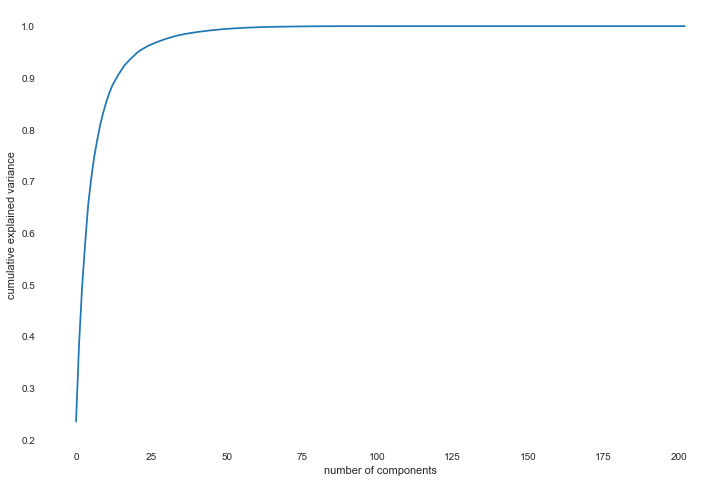

In [36]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [37]:
# Seems like its able to cober most of the variance with just 10 components
# Applying PCA
pca = PCA(random_state=100, n_components = 25)

#Doing the PCA on the train data
pca.fit(X_train_scaled_smoted)

PCA(n_components=25, random_state=100)

In [38]:
X_train_scaled_smoted_pca = pca.fit_transform(X_train_scaled_smoted)
print(X_train_scaled_smoted_pca.shape)

X_test_scaled_pca = pca.transform(X_test_scaled)
print(X_test_scaled_pca.shape)

(36578, 25)
(9889, 25)


In [39]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
logsk.fit(X_train_scaled_smoted_pca, y_train_smoted)

# Predicted probabilities
y_pred = logsk.predict(X_test_scaled_pca)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [40]:
# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[   0 9026]
 [   0  863]]


In [42]:
# Trying without SMOTE but using class weight attribute to auto in logisitc regression
# Let's run the model using the selected variables

# Applying PCA
pca = PCA(random_state=100, n_components = 25)

#Doing the PCA on the train data
pca.fit(X_train_scaled)

X_train_scaled_pca = pca.transform(X_train_scaled)
print(X_train_scaled_pca.shape)

X_test_scaled_pca = pca.transform(X_test_scaled)
print(X_test_scaled_pca.shape)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(class_weight='auto')
logsk.fit(X_train_scaled_pca, y_train)

# Predicted probabilities
y_pred = logsk.predict(X_test_scaled_pca)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

(20075, 25)
(9889, 25)


In [43]:
# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[8935   91]
 [ 742  121]]


### Seems like SMOTE did not improve the model

In [44]:
print("LogisticRegression accuracy with PCA: ",accuracy_score(y_test,y_pred))

LogisticRegression accuracy with PCA:  0.915764991404591


In [ ]:
print(classification_report(y_test,y_pred))

In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      9026
           1       0.57      0.14      0.23       863

    accuracy                           0.92      9889
   macro avg       0.75      0.57      0.59      9889
weighted avg       0.89      0.92      0.89      9889



## Approach 2 : XGBOOST with Explicability

In [58]:
from sklearn.model_selection import GridSearchCV 
from xgboost import XGBClassifier
from sklearn.utils import class_weight

In [61]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [69]:
scale_pos_weight = np.sum(y_train == 1)/ float(np.sum(y_train == 0))
clf = XGBClassifier(scale_pos_weight= scale_pos_weight)
parameters = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(clf, param_distributions=parameters, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.2min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x16ff7a1d0>,
                   estimator=XGBClassifier(scale_pos_weight=0.09765432773798458),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.9, 1.0],
                                        'eta': [0.05, 0.1, 0.3],
                                        'max_depth': [6, 9, 12],
                                        'num_boost_round': [100, 250, 500],
                                        'subsample': [0.9, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=3)

In [74]:
# Paramaetrs of Best Estimator of Grid Search CV
random_search.best_estimator_.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 0.09765432773798458,
 'seed': None,
 'silent': None,
 'subsample': 0.9,
 'verbosity': 1,
 'num_boost_round': 250,
 'eta': 0.1}

In [71]:
y_train_pred = random_search.best_estimator_.predict(X_train)
y_test_pred = random_search.best_estimator_.predict(X_test)

In [72]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18289
           1       1.00      0.31      0.47      1786

    accuracy                           0.94     20075
   macro avg       0.97      0.65      0.72     20075
weighted avg       0.94      0.94      0.92     20075



In [73]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9026
           1       0.89      0.25      0.40       863

    accuracy                           0.93      9889
   macro avg       0.91      0.63      0.68      9889
weighted avg       0.93      0.93      0.91      9889



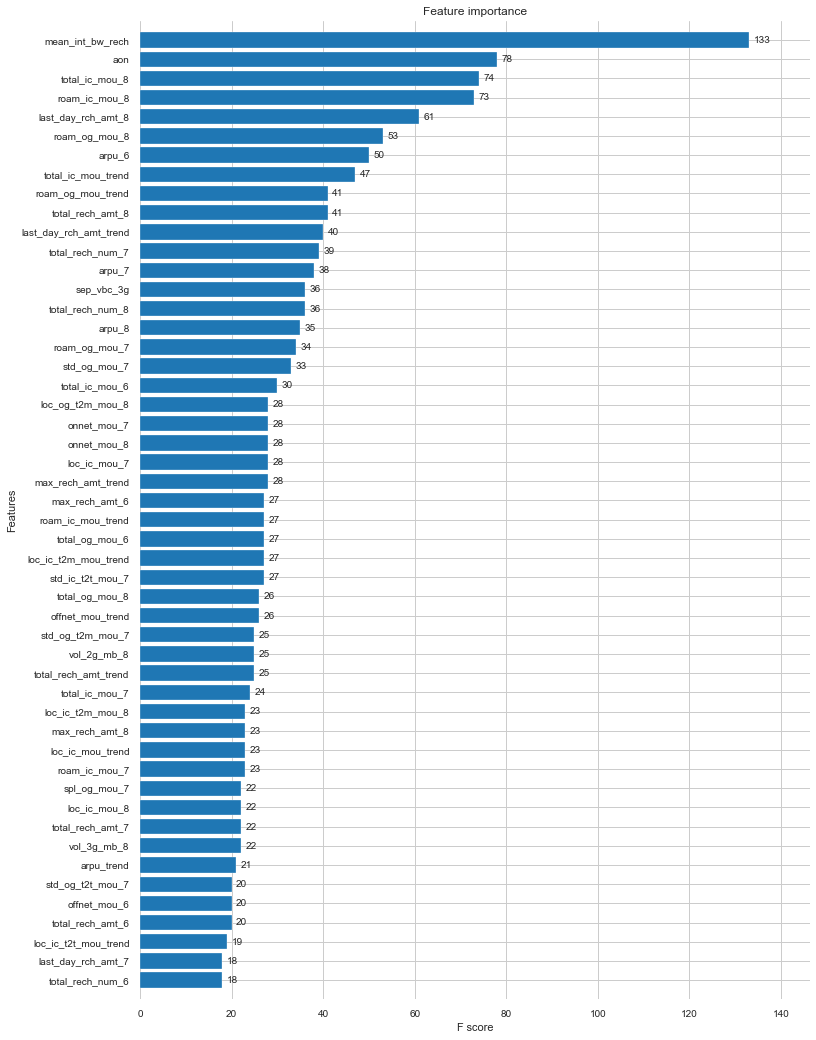

In [75]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(random_search.best_estimator_, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Note : Below are shap values which is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory

In [79]:
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(random_search.best_estimator_)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# This explains which variable/attribute had high weightage in the prediction of first customer
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

### The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. So, total_ic_mou_8 is pushing the to the non-churner side and loc_ic_mou_7 is pushing the data to churner side.

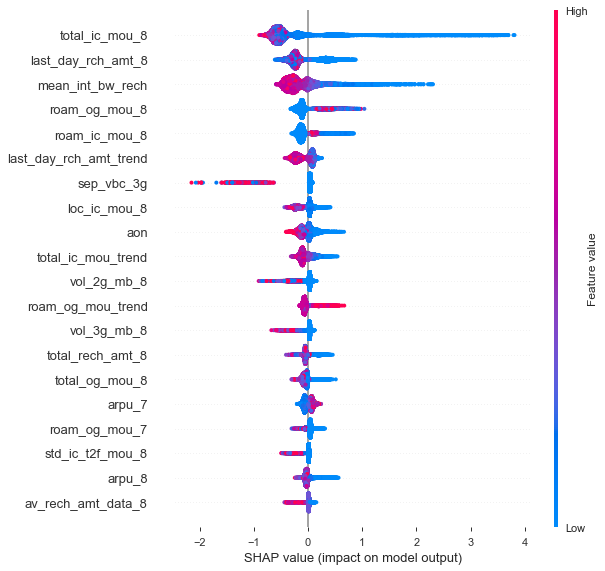

In [81]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

### To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot above sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high total_ic_mou_8  lowers the possibility of Churn.

# Conclusion

Observation: Here it is more important to identify churners than the non-churners accurately , hence we consider recall as the evaluation metric 
First Approach which is logistic regression with PCA using class_weight parameters gave us 91% accuracy and 15% recall on test data. 
Second Approach using XGBoost with GridSearch CV increased the accuracy to 94% and recall to 25% on test data.
Model Feature Importance is telling that the feature engineered i.e mean_int_bw_rech is the highest important variable which explains that mean interval between two recharge.
Others are aon, total_ic_mou_8 etc.
Shap Values help us in understanding why a customer churned.